In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #For ploting
import torch    #Pytorch
import os

In [2]:
# Look into the data directory
# first, generate figure.
data_dir = r'M:\cs230_project\virufy_small_dataset_12s_classification'
#print(os.listdir(data_dir))

#Training data directory
train_dir = (data_dir + '/train')
print('Classes:')
print(os.listdir(train_dir))

#Test data directory
test_dir = (data_dir + '/test')

Classes:
['detectable', 'nondetectable']


In [3]:
# create the datasets

In [4]:
import torchvision.transforms as tt #To apply transformations to the dataset, augmenting it and transforming it to a tensor.
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder #Load dataset

In [5]:
#Transformations aplied to test DS.
train_tf = tt.Compose([ tt.Grayscale(num_output_channels = 1),         
    tt.ColorJitter(brightness=0),
    tt.Resize(size=(150,150)),
    tt.RandomRotation(0),
    tt.ToTensor(),            
])

#Transformations aplied to test DS.
test_tf= tt.Compose([   tt.Grayscale(num_output_channels = 1), 
    tt.Resize(size=(150,150)),
    tt.ToTensor(),
])

In [6]:
train_ds = ImageFolder(train_dir,train_tf)
test_ds = ImageFolder(test_dir,test_tf)

len(train_ds), len(test_ds)

(3517, 878)

In [7]:
img,label=train_ds[0]
img.shape

torch.Size([1, 150, 150])

In [8]:
def ds_info(dataset):
    dataset_size=len(dataset)
    classes = dataset.classes
    num_classes = len(classes)
    
    #Initialize list
    count = []     
    for x in range(num_classes):
        count.append(0)
        
    #Count every label
    for x in range(dataset_size):
        count[dataset[x][1]]+=1
        
    print('Size of the dataset:' + str(dataset_size))
    print('Number of classes:' + str(num_classes))    
    print('Samples for every class:')
    
    #Print the count
    for x in range(num_classes):
        print(classes[x] + " : " + str(count[x]))
    

In [9]:
print('Training dataset information:')
ds_info(train_ds)

Training dataset information:
Size of the dataset:3517
Number of classes:2
Samples for every class:
detectable : 1757
nondetectable : 1760


In [10]:
print('Test dataset information:')
ds_info(test_ds)


Test dataset information:
Size of the dataset:878
Number of classes:2
Samples for every class:
detectable : 439
nondetectable : 439


In [11]:
batch_size = 254

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=True,
    pin_memory=True
)

test_dl = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=False,
    pin_memory=True
)

In [12]:
from torchvision.utils import make_grid

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

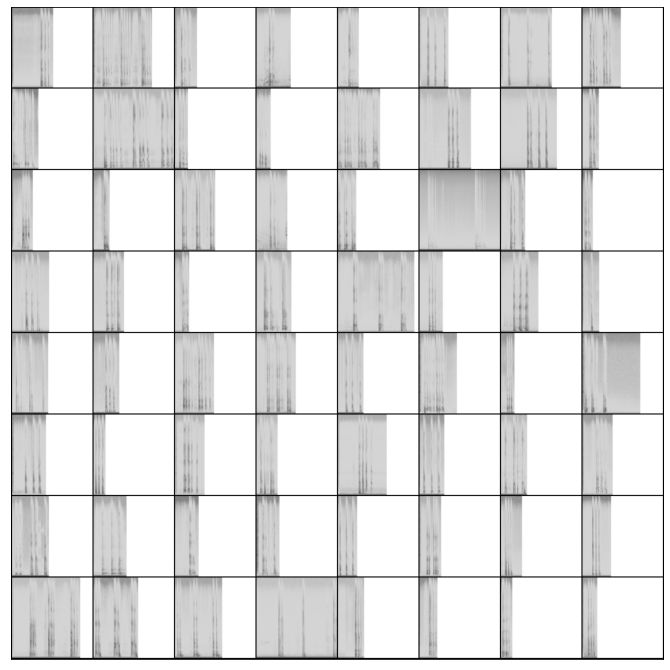

In [14]:
%matplotlib inline
show_batch(train_dl)

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device() #Getting the device
device

train_dl = DeviceDataLoader(train_dl, device) #Transfering train data to GPU
test_dl = DeviceDataLoader(test_dl, device)   #Transfering test data to GPU

In [17]:
# create network

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return {'train_loss': loss, 'train_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f},train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            (epoch+1), result['lrs'][-1], result['train_loss'], result['train_acc'],result['val_loss'], result['val_acc']))

In [21]:
def conv_block(in_channels, out_channels, pool=False,p_size=2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(p_size))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)                             #32x150x150
        self.conv2 = conv_block(32, 64, pool=True,p_size=4)                  #64x37x37
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True,p_size=4)                 #128x9x9
        self.conv4 = conv_block(128, 256, pool=True,p_size=4)                #256x2x2
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),                     #256x1x1
                                        nn.Flatten(), 
                                        nn.Linear(256, num_classes))
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        
        out = self.classifier(out)
        
        return out

In [22]:
from tqdm.notebook import tqdm

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_acces = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)['train_loss']
            acc = model.training_step(batch)['train_acc']
            train_losses.append(loss)
            train_acces.append(acc)
            loss.backward()

            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acces).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
def plot_scores(history):
    train_acc = [x.get('train_acc') for x in history]
    val_scores = [x['val_acc'] for x in history]
    plt.plot(train_acc,'-bx')
    plt.plot(val_scores, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylabel(['Training','Validation'])
    plt.title('Accuracy vs. No. of epochs');

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [26]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    show_sample(img,test_ds.classes[preds[0].item()])

In [27]:
#ResNet9

In [30]:
model = to_device(ResNet9(1,2), device) # two classes 0 and 1
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [31]:
history = [evaluate(model, test_dl)]
history

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_loss': 0.6933121681213379, 'val_acc': 0.43344420194625854}]

In [32]:
epochs = 20
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [40]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00010, train_loss: 0.9869,train_acc: 0.5022, val_loss: 0.7852, val_acc: 0.5679


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00027, train_loss: 0.7115,train_acc: 0.5179, val_loss: 0.6925, val_acc: 0.5391


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00051, train_loss: 0.6842,train_acc: 0.5634, val_loss: 0.6975, val_acc: 0.5188


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00075, train_loss: 0.6799,train_acc: 0.5769, val_loss: 0.7206, val_acc: 0.5160


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00093, train_loss: 0.7051,train_acc: 0.5759, val_loss: 0.7461, val_acc: 0.4802


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00100, train_loss: 0.6653,train_acc: 0.5898, val_loss: 0.6883, val_acc: 0.5773


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00099, train_loss: 0.6492,train_acc: 0.6203, val_loss: 0.7493, val_acc: 0.4905


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00095, train_loss: 0.6353,train_acc: 0.6401, val_loss: 0.7350, val_acc: 0.5014


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00089, train_loss: 0.6009,train_acc: 0.6631, val_loss: 0.6961, val_acc: 0.5771


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00081, train_loss: 0.5828,train_acc: 0.6845, val_loss: 0.8430, val_acc: 0.5692


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00072, train_loss: 0.5470,train_acc: 0.7207, val_loss: 0.7451, val_acc: 0.5366


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00061, train_loss: 0.4617,train_acc: 0.7839, val_loss: 0.8134, val_acc: 0.5668


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00050, train_loss: 0.4454,train_acc: 0.7862, val_loss: 0.8109, val_acc: 0.5725


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00039, train_loss: 0.3847,train_acc: 0.8242, val_loss: 0.8435, val_acc: 0.5684


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00028, train_loss: 0.2358,train_acc: 0.9025, val_loss: 1.0410, val_acc: 0.5893


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00019, train_loss: 0.1429,train_acc: 0.9507, val_loss: 1.1585, val_acc: 0.5768


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00011, train_loss: 0.0654,train_acc: 0.9878, val_loss: 1.4004, val_acc: 0.5491


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00005, train_loss: 0.0324,train_acc: 0.9949, val_loss: 1.4377, val_acc: 0.5740


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00001, train_loss: 0.0177,train_acc: 0.9994, val_loss: 1.5050, val_acc: 0.5783


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00000, train_loss: 0.0157,train_acc: 1.0000, val_loss: 1.4692, val_acc: 0.5749
Wall time: 6min 9s


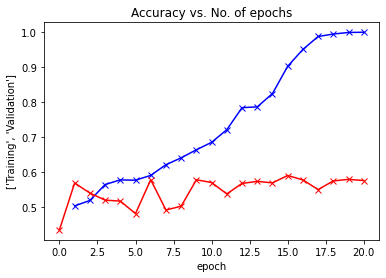

In [41]:
plot_scores(history)

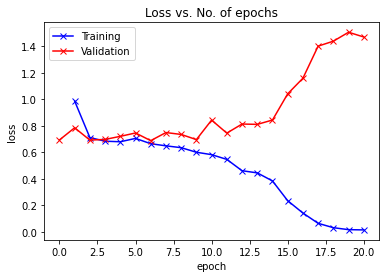

In [42]:
plot_losses(history)

In [59]:
class model18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        self.network.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [60]:
model = to_device(model18(), device)
model

model18(
  (network): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [61]:
history = [evaluate(model, test_dl)]
history

[{'val_loss': 0.6997071504592896, 'val_acc': 0.43208661675453186}]

In [62]:
epochs = 20
epochs2 = 20
max_lr2 = 0.00005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [63]:
model.freeze()

In [64]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00000, train_loss: 0.6975,train_acc: 0.5051, val_loss: 0.7119, val_acc: 0.4311


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00001, train_loss: 0.6895,train_acc: 0.5434, val_loss: 0.7234, val_acc: 0.4507


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00003, train_loss: 0.6774,train_acc: 0.5735, val_loss: 0.7114, val_acc: 0.4734


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00004, train_loss: 0.6585,train_acc: 0.6343, val_loss: 0.7004, val_acc: 0.5107


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00005, train_loss: 0.6287,train_acc: 0.7030, val_loss: 0.7014, val_acc: 0.5012


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00005, train_loss: 0.5847,train_acc: 0.7773, val_loss: 0.6909, val_acc: 0.5504


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00005, train_loss: 0.5226,train_acc: 0.8456, val_loss: 0.7022, val_acc: 0.5292


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00005, train_loss: 0.4611,train_acc: 0.9044, val_loss: 0.7021, val_acc: 0.5596


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00004, train_loss: 0.4098,train_acc: 0.9465, val_loss: 0.7121, val_acc: 0.5360


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00004, train_loss: 0.3782,train_acc: 0.9672, val_loss: 0.7133, val_acc: 0.5363


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00004, train_loss: 0.3528,train_acc: 0.9836, val_loss: 0.7195, val_acc: 0.5372


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00003, train_loss: 0.3394,train_acc: 0.9906, val_loss: 0.7363, val_acc: 0.5240


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00003, train_loss: 0.3315,train_acc: 0.9952, val_loss: 0.7366, val_acc: 0.5262


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00002, train_loss: 0.3262,train_acc: 0.9979, val_loss: 0.7415, val_acc: 0.5063


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00001, train_loss: 0.3236,train_acc: 0.9980, val_loss: 0.7399, val_acc: 0.5144


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00001, train_loss: 0.3224,train_acc: 0.9986, val_loss: 0.7420, val_acc: 0.5120


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00001, train_loss: 0.3210,train_acc: 0.9991, val_loss: 0.7374, val_acc: 0.5152


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00000, train_loss: 0.3210,train_acc: 0.9992, val_loss: 0.7355, val_acc: 0.5179


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00000, train_loss: 0.3206,train_acc: 0.9992, val_loss: 0.7384, val_acc: 0.5093


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00000, train_loss: 0.3209,train_acc: 0.9992, val_loss: 0.7394, val_acc: 0.5167
Wall time: 5min 52s


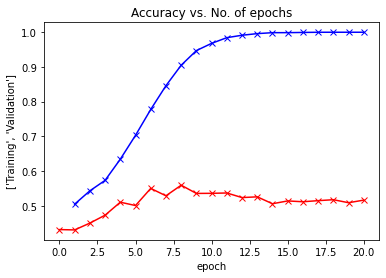

In [65]:
plot_scores(history)

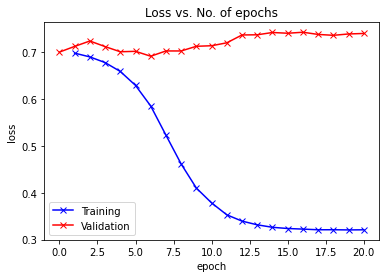

In [66]:
plot_losses(history)

In [67]:
model.unfreeze()

In [68]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00000, train_loss: 0.3206,train_acc: 0.9992, val_loss: 0.7426, val_acc: 0.5199


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00001, train_loss: 0.3200,train_acc: 0.9988, val_loss: 0.7370, val_acc: 0.5397


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00003, train_loss: 0.3192,train_acc: 0.9989, val_loss: 0.7372, val_acc: 0.5346


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00004, train_loss: 0.3218,train_acc: 0.9966, val_loss: 0.7691, val_acc: 0.4995


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00005, train_loss: 0.3216,train_acc: 0.9978, val_loss: 0.7138, val_acc: 0.5679


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00005, train_loss: 0.3415,train_acc: 0.9795, val_loss: 0.7532, val_acc: 0.5210


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00005, train_loss: 0.3415,train_acc: 0.9789, val_loss: 0.7506, val_acc: 0.5052


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00005, train_loss: 0.3303,train_acc: 0.9907, val_loss: 0.7658, val_acc: 0.4974


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00004, train_loss: 0.3242,train_acc: 0.9932, val_loss: 0.7510, val_acc: 0.5183


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00004, train_loss: 0.3196,train_acc: 0.9975, val_loss: 0.7368, val_acc: 0.5440


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00004, train_loss: 0.3161,train_acc: 0.9994, val_loss: 0.7466, val_acc: 0.5242


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00003, train_loss: 0.3150,train_acc: 0.9994, val_loss: 0.7553, val_acc: 0.5164


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00003, train_loss: 0.3147,train_acc: 0.9994, val_loss: 0.7555, val_acc: 0.5136


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00002, train_loss: 0.3147,train_acc: 0.9994, val_loss: 0.7562, val_acc: 0.5245


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00001, train_loss: 0.3145,train_acc: 0.9994, val_loss: 0.7537, val_acc: 0.5170


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00001, train_loss: 0.3145,train_acc: 0.9994, val_loss: 0.7558, val_acc: 0.5178


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00001, train_loss: 0.3144,train_acc: 0.9994, val_loss: 0.7559, val_acc: 0.5146


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00000, train_loss: 0.3144,train_acc: 0.9994, val_loss: 0.7539, val_acc: 0.5180


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00000, train_loss: 0.3144,train_acc: 0.9994, val_loss: 0.7557, val_acc: 0.5128


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00000, train_loss: 0.3144,train_acc: 0.9994, val_loss: 0.7542, val_acc: 0.5188
Wall time: 5min 56s


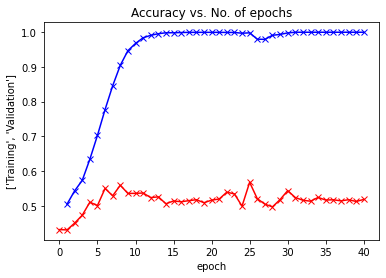

In [69]:
plot_scores(history)

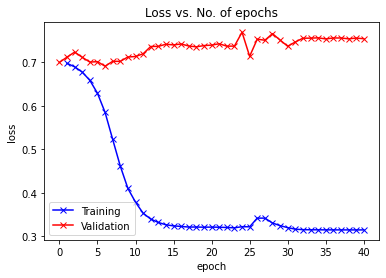

In [70]:
plot_losses(history)

In [71]:
model

model18(
  (network): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run